First install all the necessary dependencies:

In [1]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install Image
import PIL.Image

  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [31]:
!pip install PyDrive
!pip install git+https://github.com/fastai/fastai.git



  Cloning https://github.com/fastai/fastai.git to /tmp/pip-req-build-cr5z141k
  Running setup.py bdist_wheel for fastai ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-tij9ativ/wheels/cf/46/39/b2d08762125ed2376861976ab2c4ac30c029b86e375735d9b8
Successfully built fastai


This next part is for downloading the necessary files hosted on Drive:

In [0]:
import os
import shutil
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# fill with whatever IDs you need

#Train_id = '1eSmyVKwBLaHVDqBq9K_CHq1pvnZ9v68H'
#Test_id = '1GvzCkUaA1HgiRcfIyk43FWK8TC3fVke7'
#train_annos_id = '1h7JPRNmhbgruhXrTf9jGaP0KYcEKe6p7'
#test_annos_id = '1pM7-uucfLleXlCUyGFWk55mm7roFBqNN'
#meta_id = '1FZXdIE8U1dmFQBSYm5RBIKDVLmRN17Ig'

car_ims_id = '1tAeKbRYU0rScNPXl705V8XwMt_-AlnML'
cars_annos_id = '1pJ5yzvi6yrIdxw3MOyDhV_xZl3dPP6vw'

Download all the files from Drive

In [0]:
ids = [
    car_ims_id,
    cars_annos_id
]
fnames = [
    'car_ims.tgz',
    'cars_annos.mat'
]
downloads = [drive.CreateFile({'id': ID}) for ID in ids]
for j, download in enumerate(downloads):
    download.GetContentFile(fnames[j])

Untar the image files

In [36]:
# train length 8144 images
# test length 8041 images
!tar xf car_ims.tgz
!ls

adc.json  car_ims.tgz	  models       tmp    valid
car_ims   cars_annos.mat  sample_data  train


Load the .mat files into numpy

In [0]:
import random
import numpy as np
import pandas as pd
import numpy.random as rng
import matplotlib.pyplot as plt

In [0]:
from scipy import ndimage
from scipy.misc import imread

In [0]:
import scipy.io
annos = scipy.io.loadmat('cars_annos.mat')

Now begin looking at the metadata in the loaded .mat files:

In [40]:
annos.keys()

dict_keys(['__header__', '__version__', '__globals__', 'annotations', 'class_names'])

Display a few class names to see how the labeling scheme corresponds to class numbers

In [41]:
classes = pd.DataFrame(annos['class_names'])
classes.transpose().head()

,0
0,[AM General Hummer SUV 2000]
1,[Acura RL Sedan 2012]
2,[Acura TL Sedan 2012]
3,[Acura TL Type-S 2008]
4,[Acura TSX Sedan 2012]


Grab the annotations for the training set (class numbers and filenames) by indexing into the .mat 
file that was converted into a numpy array

In [0]:
annotations = np.array(annos['annotations'])

In [43]:
len(annotations[0])

16185

In [0]:
# Rubric: annotations[0] is the matrix of data
# [0][i] is the ith row of the matrix
# [0][i][j] is the (i,j)th element of the matrix
# j = 0 is fname, 1 is bboxx1, 2 is bboxy1, 
# 3 is bboxx2, 4 is bboxy2, 5 is class, 6 is bool(test)
# to get the fname, append [0]
# to get all others, append [0][0]


In [0]:
from collections import defaultdict

#classes are minus 1 to convert MATLAB indexing

train_fnames = [annotations[0][i][0][0] for i in range(len(annotations[0]))
                if annotations[0][i][6][0][0] == 0]
train_classes = [annotations[0][ii][5][0][0] - 1 for ii in range(len(annotations[0]))
                if annotations[0][ii][6][0][0] == 0]

test_fnames = [annotations[0][i][0][0] for i in range(len(annotations[0]))
                if annotations[0][i][6][0][0] == 1]
test_classes = [annotations[0][ii][5][0][0] - 1 for ii in range(len(annotations[0]))
                if annotations[0][ii][6][0][0] == 1]

train_data = zip(train_classes, train_fnames)
test_data = zip(test_classes, test_fnames)

train_dict = defaultdict(list)
test_dict = defaultdict(list)

for tr_cl, tr_fname in train_data:
    train_dict[tr_cl].append(tr_fname)
    
for ts_cl, ts_fname in test_data:
    test_dict[ts_cl].append(ts_fname)


Using the dictionaries, we can view sample images belonging to a particular class from both the training and test sets:

['car_ims/009948.jpg', 'car_ims/009949.jpg', 'car_ims/009950.jpg', 'car_ims/009951.jpg']


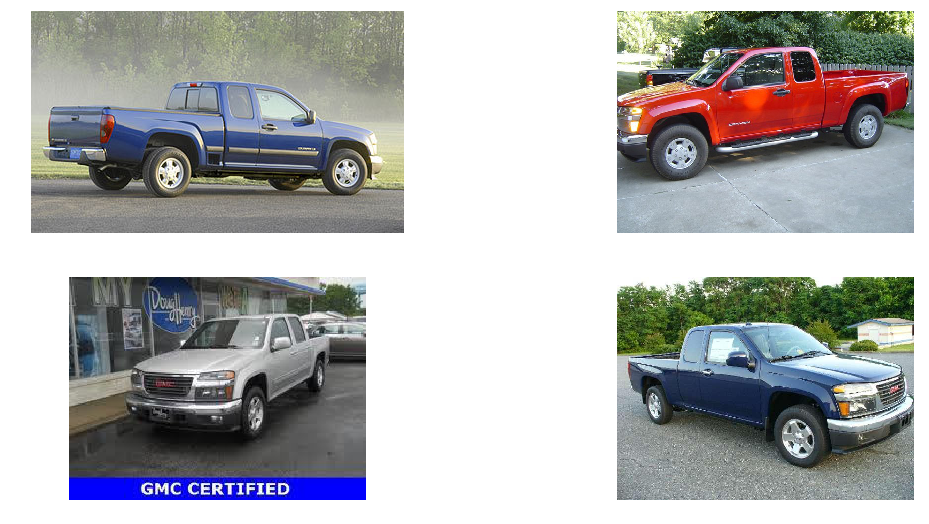

In [45]:
# Look at several images from the training set
rand_cl = rng.choice(196)
print(train_dict[rand_cl][0:4])

fig=plt.figure(figsize=(18, 9))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    img = imread(train_dict[rand_cl][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.show() 


['car_ims/009988.jpg', 'car_ims/009989.jpg', 'car_ims/009990.jpg', 'car_ims/009991.jpg']


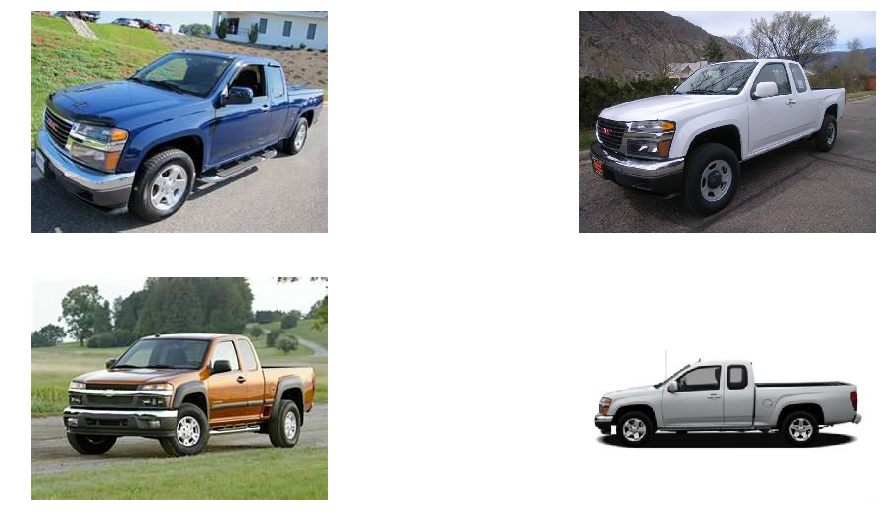

In [46]:
# Look at several images from the testing set
print(test_dict[rand_cl][0:4])

fig=plt.figure(figsize=(18, 9))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    img = imread(test_dict[rand_cl][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [47]:
!ls

adc.json  car_ims.tgz	  models       tmp    valid
car_ims   cars_annos.mat  sample_data  train


In [0]:
# Make train and validation folders for fastai dataloader

if os.path.exists('./train'):
    shutil.rmtree('./train')
if os.path.exists('./valid'):
    shutil.rmtree('./valid')
    
!mkdir ./train
!mkdir ./valid

# Populate the class folders with images
for cl in train_dict.keys():
    train_folder = './train/' + str(cl) + "/"
    valid_folder = './valid/' + str(cl) + "/"
    if not os.path.exists(train_folder):
        os.mkdir(train_folder)
    if not os.path.exists(valid_folder):
        os.mkdir(valid_folder)
        
    for tr_img in train_dict[cl]:
        shutil.copy(tr_img, train_folder)
    for val_img in test_dict[cl]:
        shutil.copy(val_img, valid_folder)       

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
import skimage

In [0]:
def get_data(sz, bs=64, arch=resnet50, aug_tfms=transforms_side_on):
    tfms = tfms_from_model(arch, sz, 
                       aug_tfms=aug_tfms, 
                       max_zoom=1.05)
    data = ImageClassifierData.from_paths('', bs=bs, tfms=tfms)
    return data

arch = resnet50
sz = 224
aug_tfms = transforms_side_on
#aug_tfms += [GoogleNetResize(targ_sz=sz)]
# This custom head doesn't work yet.
# Possibly find out how to modify the custom head on the fly?
custom_head = nn.Sequential(
                AdaptiveConcatPool2d(),
                Flatten(),
                nn.BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True),
                nn.Dropout(p=0.25),
                nn.Linear(4096, 512, bias=True),
                nn.ReLU(),
                nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True),
                nn.Dropout(p=0.25),
                nn.Linear(512, 196, bias=True),
                nn.LogSoftmax())
data = get_data(sz, bs=64, aug_tfms=aug_tfms)

In [0]:
learn = ConvLearner.pretrained(arch, data, custom_head=None, precompute=True)

In [0]:
learn.opt_fn = optim.Adam

In [77]:
learn.summary

<bound method ConvLearner.summary of Sequential(
  (0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True)
  (1): Dropout(p=0.25)
  (2): Linear(in_features=4096, out_features=512, bias=True)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=512, out_features=196, bias=True)
  (7): LogSoftmax()
)>

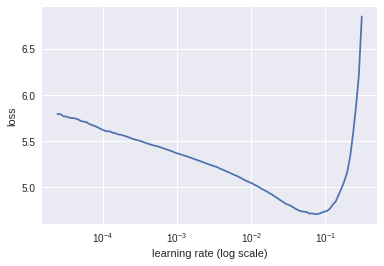

In [78]:
lrf=learn.lr_find(wds = 1e-2, use_wd_sched=True, start_lr=1e-05, end_lr=1)
learn.sched.plot()

In [0]:
#Use this to plot your losses after running a learn.fit
#result, ep_vals = learn.fit(…, get_ep_vals=True)

In [79]:
learn.fit(3e-2, 1, cycle_len=20, use_clr_beta=(10, 10, 0.95, 0.85), wds=1e-2, use_wd_sched=True)

epoch      trn_loss   val_loss   accuracy   
    0      3.865492   3.528214   0.226589  
    1      3.216789   2.989514   0.280189  
    2      3.19572    3.201896   0.237533  
    3      3.220437   3.139281   0.250839  
    4      3.359354   3.548026   0.190772  
    5      3.444313   3.301068   0.216391  
    6      3.453514   3.389077   0.190524  
    7      3.649943   3.674322   0.163786  
    8      3.712837   3.9919     0.133192  
    9      3.635228   3.351087   0.210546  
    10     3.475332   3.201348   0.229449  
    11     3.41551    3.205586   0.237657  
    12     3.280121   3.094081   0.267877  
    13     3.16949    3.026582   0.28193   
    14     3.134164   2.928626   0.30444   
    15     3.02766    2.967076   0.305062  
    16     2.942195   3.000152   0.333168  
    17     3.07175    3.358181   0.36973   
    18     3.604725   4.056049   0.375202  
    19     4.505103   4.975471   0.299092  


[array([4.97547]), 0.2990921527469741]

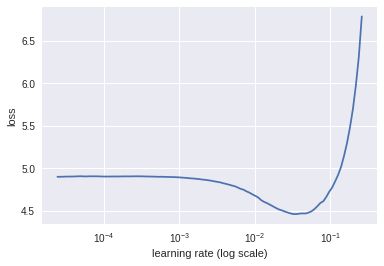

In [81]:
lrf=learn.lr_find(wds = 1e-3, use_wd_sched=True, start_lr=1e-05, end_lr=1)
learn.sched.plot()

In [0]:
lr2 = 1.5e-2

In [0]:
lrs = np.array([lr2/100,lr2/10,lr2])

In [0]:
learn.unfreeze()
learn.fit(lrs, 1, cycle_len=40, use_clr_beta=(10, 10, 0.95, 0.85), wds=1e-3, use_wd_sched=True)

epoch      trn_loss   val_loss   accuracy   
    0      3.722825   2.970221   0.28877   
    1      2.782123   2.392495   0.384654  
    2      2.525632   2.264904   0.413381  
    3      2.361273   2.183733   0.429051  
    4      2.330022   2.174819   0.437259  
    5      2.255271   2.122523   0.444223  
    6      2.233112   2.122646   0.445591  
    7      2.23995    2.213717   0.424698  
 10%|█         | 13/128 [00:19<01:52,  1.02it/s, loss=2.22]

In [0]:
log_preds, y = learn.TTA()

In [0]:
probs = np.exp(log_preds)

In [0]:
avg_TTA = np.mean(probs, axis = 0)

In [0]:
preds = np.argmax(avg_TTA,axis=1)
targs = y

In [0]:
TTA_acc = (preds==targs).mean()
print(TTA_acc)

In [0]:
plt.hist(preds, bins=195)